In [1]:
pip install - q optax dm-haiku

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
import haiku as hk

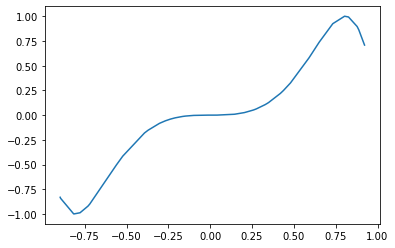

In [3]:
S = np.array([-0.8964536, -0.8937423, -0.8160014, -0.8135896, -0.7777178,
              -0.7306509, -0.7196269, -0.56077266, -0.5225189, -0.39259458,
              -0.37080932, -0.30425978, -0.30012155, -0.26793814, -0.23755741,
              -0.20966339, -0.16642046, -0.15392852, -0.14616823, -0.09809828,
              -0.01211524,  0.02200961,  0.0394454,  0.04127908,  0.14237666,
              0.1488111,  0.20493412,  0.25775242,  0.2756691,  0.32817745,
              0.3374791,  0.34276915,  0.34953642,  0.41928077,  0.4337349,
              0.43921685,  0.4798982,  0.5894067,  0.5936425,  0.6099713,
              0.64054966,  0.6516247,  0.7327845,  0.8028183,  0.803761,
              0.82667255,  0.8778291,  0.879761,  0.8880968,  0.92238617])

payoff = np.array([-8.30690000e-01, -8.41413975e-01, -9.98246000e-01, -9.98990000e-01,
                   -9.87290919e-01, -9.20819000e-01, -8.99229109e-01, -5.04697680e-01,
                   -4.15037155e-01, -1.80537000e-01, -1.52362585e-01, -8.43991116e-02,
                   -8.10096189e-02, -5.76740000e-02, -4.02077623e-02, -2.76460908e-02,
                   -1.38269800e-02, -1.09413229e-02, -9.36858000e-03, -2.83207800e-03,
                   -5.33478988e-06,  3.19850000e-05,  1.84123986e-04,  2.11016000e-04,
                   8.65829000e-03,  9.88599000e-03,  2.58175954e-02,  5.13450000e-02,
                   6.28057718e-02,  1.05835974e-01,  1.15053318e-01,  1.20522849e-01,
                   1.27764000e-01,  2.19326511e-01,  2.42352000e-01,  2.51461000e-01,
                   3.25523138e-01,  5.76370418e-01,  5.87219000e-01,  6.29451275e-01,
                   7.09268000e-01,  7.37970000e-01,  9.24770000e-01,  9.99828756e-01,
                   9.99915123e-01,  9.92319000e-01,  8.96705747e-01,  8.90681505e-01,
                   8.62517000e-01,  7.08453476e-01])

plt.plot(S, payoff)

# 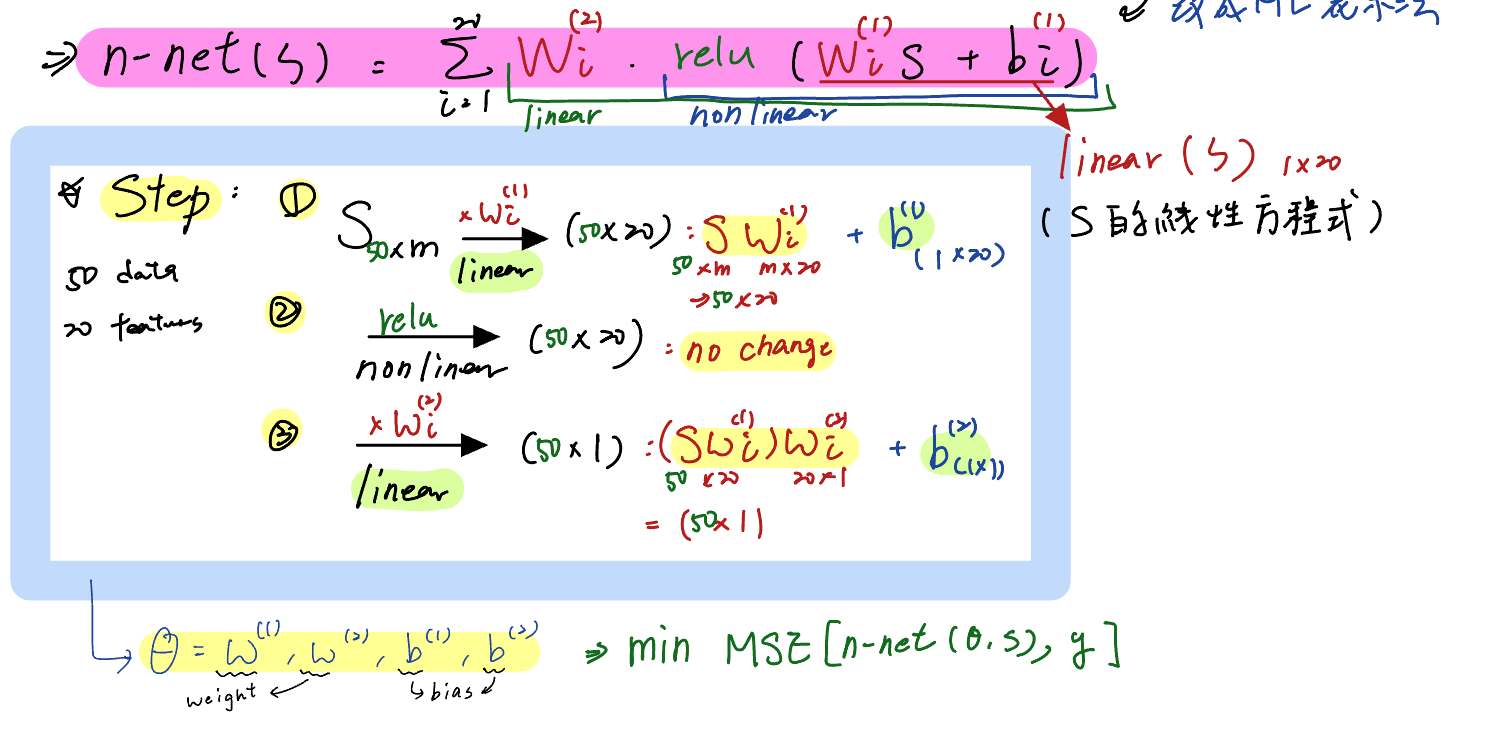

In [21]:
#Create weights and bias
W1 = np.random.normal(size=[1,128])
b1 = np.random.normal(size=[1,128])

W2 = np.random.normal(size=[128,1])
b2 = np.random.normal(size=[1,1])

Θ = W1, b1, W2, b2

#Redefine the shape of S so that we can put it into calculation
S = S.reshape(50, 1)

In [22]:
# 把上面的n-net寫成扣
def nnet(Θ, S):
    W1, b1, W2, b2 = Θ

    # Step1: linear transf.
    out = S @ W1 + b1

    # Step2: non-linear transf.
    out = jax.nn.relu(out)

    # Step3: linear transf.
    out = out @ W2 + b2

    return out

In [23]:
# Use optax to do the minimization
optimizer = optax.adam
lr = 1e-3  # learning rate
opt_state = optimizer(lr).init(Θ)  # 係數


@jax.jit
def update(Θ, opt_state):
    def L(Θ):
        predictions = nnet(Θ, S)
        return ((predictions.ravel() - payoff)**2).mean()
    grad = jax.grad(L)(Θ)  # Calculating gradient
    updates, opt_state = optimizer(lr).update(grad, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state

In [82]:
for i in range(10000):
    Θ, opt_state = update(Θ, opt_state)

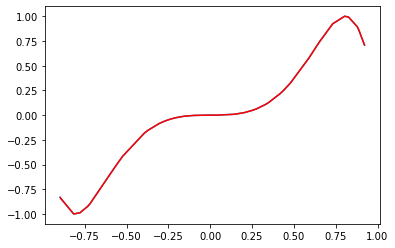

In [83]:
predictions = nnet(Θ, S)

plt.plot(S, payoff)
plt.plot(S, predictions, color='r')

# 用Haiku優化gradient 過程

In [84]:
# Advantage 1:不用自己設Theta，haiku會幫你。

optimizer = optax.adam
lr = 1e-3  # learning rate

def nnet(S):
    # Step1: linear transf.
    out = hk.Linear(128)(S)  # 變成用１２８個feature表示

    # Step2: non-linear transf.
    out = jax.nn.relu(out)

    # Step3: linear transf.
    out = hk.Linear(1)(out)  # 變成用１個feature表示
    return out

In [85]:
#Haiku 要這樣開機
init, nnet = hk.without_apply_rng(hk.transform(nnet))

rng = jax.random.PRNGKey(0) #random generator key (seed, the place to start optimization)
Θ = init(rng, S)
opt_state = optimizer(lr).init(Θ)

/opt/anaconda3/lib/python3.8/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [86]:
@jax.jit
def update(Θ, opt_state):
    def L(Θ):
        predictions = nnet(Θ, S)
        return ((predictions.ravel() - payoff)**2).mean()
    grad = jax.grad(L)(Θ)  # Calculating gradient
    updates, opt_state = optimizer(lr).update(grad, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state

In [87]:
for i in range(10000):
    Θ, opt_state = update(Θ, opt_state)

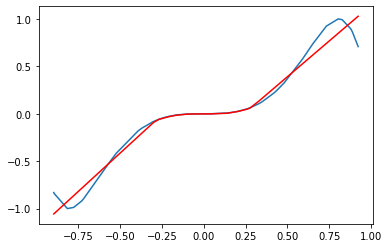

In [88]:
predictions = nnet(Θ, S)

plt.plot(S, payoff)
plt.plot(S, predictions, color='r')

# 用haiku改成two layers (Convinient)

In [89]:
optimizer = optax.adam
lr = 1e-3  

#Only have to modify here
def nnet(S):
    #double layers
    out = hk.Linear(128)(S) 

    out = jax.nn.relu(out)
    out = hk.Linear(256)(out) 

    out = jax.nn.relu(out)
    out = hk.Linear(1)(out)
    return out

In [90]:
#Haiku 要這樣開機
init, nnet = hk.without_apply_rng(hk.transform(nnet))

rng = jax.random.PRNGKey(0) #random generator key (seed, the place to start optimization)
Θ = init(rng, S)
opt_state = optimizer(lr).init(Θ)

/opt/anaconda3/lib/python3.8/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [91]:
@jax.jit
def update(Θ, opt_state):
    def L(Θ):
        predictions = nnet(Θ, S)
        return ((predictions.ravel() - payoff)**2).mean()
    grad = jax.grad(L)(Θ)  # Calculating gradient
    updates, opt_state = optimizer(lr).update(grad, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state

In [92]:
for i in range(10000):
    Θ, opt_state = update(Θ, opt_state)

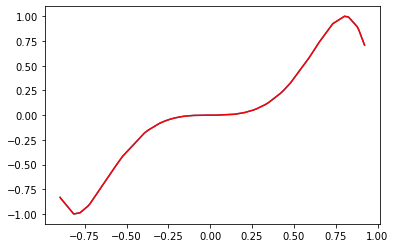

In [93]:
predictions = nnet(Θ, S)

plt.plot(S, payoff)
plt.plot(S, predictions, color='r')

two layer非常fit!